# Install and import dependencies
We'll need TensorFlow Datasets, an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

In [1]:
!pip install -U tensorflow_datasets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import math
import matplotlib.pyplot as plt

# Import the Fashion MNIST dataset
This guide uses the Fashion MNIST dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 × 28 pixels), as seen here:

Fashion MNIST sprite
Figure 1. Fashion-MNIST samples (by Zalando, MIT License).
 
Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, using the Datasets API:

In [3]:
database, metadata = tfds.load('fashion_mnist',as_supervised=True, with_info=True)
train_data,  test_data = database['train'], database['test']

Loading the dataset returns metadata as well as a training dataset and test dataset.

The model is trained using train_dataset.
The model is tested against test_dataset.
The images are 28  ×  28 arrays, with pixel values in the range [0, 255]. The labels are an array of integers, in the range [0, 9]. These correspond to the class of clothing the image represents:

Label	Class
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [4]:
#Storing Class names in a variable
class_names = metadata.features["label"].names
print("Class Names: {}".format(class_names))

Class Names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Explore the data
Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [5]:
train_example = metadata.splits['train'].num_examples
test_example = metadata.splits['test'].num_examples
print("The Number of Training Samples are: ", train_example)
print("The Number of Testing Samples are: ", test_example)

The Number of Training Samples are:  60000
The Number of Testing Samples are:  10000


# Preprocess the data
The value of each pixel in the image data is an integer in the range [0,255]. For the model to work properly, these values need to be normalized to the range [0,1]. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [6]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images = images/255
    return images , labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_data = train_data.map(normalize)
test_data = test_data.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster

train_data = train_data.cache()
test_data = test_data.cache()

# Explore the processed data
Let's plot an image to see what it looks like.

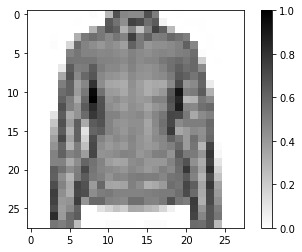

In [7]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_data.take(1):
    break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

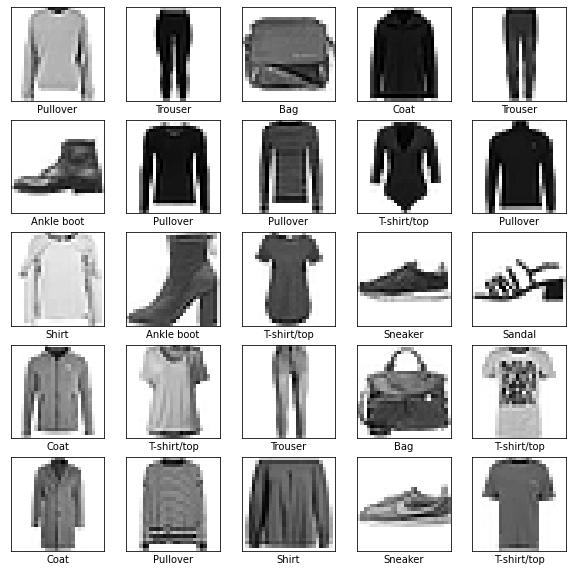

In [8]:
plt.figure(figsize = (10,10))
for i ,(image, label) in enumerate(train_data.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

# Build the model
Building the neural network requires configuring the layers of the model, then compiling the model.

# Setup the layers
The basic building block of a neural network is the layer. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like tf.keras.layers.Dense, have internal parameters which are adjusted ("learned") during training.

In [9]:
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = (28,28,1)))
    model.add(tf.keras.layers.Dense(units = 128, activation = "relu"))
    model.add(tf.keras.layers.Dense(units = 10, activation= tf.nn.softmax))
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=tf.keras.metrics.Accuracy())
    return model

In [10]:
#Another Way
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# This network has three layers:

input tf.keras.layers.Flatten — This layer transforms the images from a 2d-array of 28  ×  28 pixels, to a 1d-array of 784 pixels (28*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

"hidden" tf.keras.layers.Dense— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

output tf.keras.layers.Dense — A 128-neuron, followed by 10-node softmax layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range [0, 1], representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

Note: Using softmax activation and SparseCategoricalCrossentropy() has issues and which are patched by the tf.keras model. A safer approach, in general, is to use a linear output (no activation function) with SparseCategoricalCrossentropy(from_logits=True).

# Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

Loss function — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
Optimizer —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


In [11]:
#Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
First, we define the iteration behavior for the train dataset:

Repeat forever by specifying dataset.repeat() (the epochs parameter described below limits how long we perform training).
The dataset.shuffle(60000) randomizes the order so our model cannot learn anything from the order of the examples.
And dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables.
Training is performed by calling the model.fit method:

Feed the training data to the model using train_dataset.
The model learns to associate images and labels.
The epochs=5 parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.
(Don't worry about steps_per_epoch, the requirement to have this flag will soon be removed.)

In [12]:
#Shuffling the data
batch_size = 32
train_data = train_data.cache().repeat().shuffle(train_example).batch(batch_size)
test_data = test_data.cache().batch(batch_size)

In [13]:
model.fit(train_data, epochs=5, steps_per_epoch=math.ceil(train_example/batch_size))

Epoch 1/5
1875/1875 [==============================] - 7s 2ms/step - loss: 0.4979 - accuracy: 0.8242
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3714 - accuracy: 0.8652
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3377 - accuracy: 0.8763
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3134 - accuracy: 0.8852
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2904 - accuracy: 0.8921


# Evaluate accuracy
Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [14]:
test_accuracy = model.evaluate(test_data, steps = math.ceil(test_example/batch_size))
print(test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.3480 - accuracy: 0.8746
[0.3480076789855957, 0.8745999932289124]


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the train_dataset. When the model sees images it has never seen during training, (that is, from the test_dataset), we can expect performance to go down.



# Make predictions and explore
With the model trained, we can use it to make predictions about some images.

In [15]:
for test_images, test_labels in test_data.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions  = model.predict(test_images)

In [16]:
predictions.shape

(32, 10)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [17]:
predictions[0]

array([3.74224706e-04, 1.14775485e-05, 1.64299123e-02, 2.07198946e-06,
       9.51961994e-01, 8.26558377e-09, 3.11205462e-02, 5.19778993e-08,
       9.94186485e-05, 1.99641207e-07], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [18]:
np.argmax(predictions[0])

4

So the model is most confident that this image is a shirt, or class_names[6]. And we can check the test label to see this is correct:

In [19]:
test_labels[0]

4

We can graph this to look at the full set of 10 class predictions

In [29]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  
    plt.imshow(img[...,0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],100*np.max(predictions_array),class_names[true_label]),
               color=color)
def plot_value_array(i, predictions_array, true_label):
    pred_array, true_labels = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), pred_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(pred_array)
  
    thisplot[predicted_label].set_color('red')
    thisplot[true_labels].set_color('blue')

Let's look at the 0th image, predictions, and prediction array.



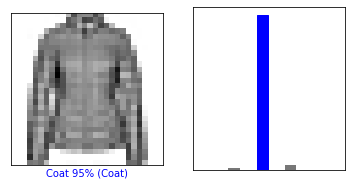

In [30]:
ith_term = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1) #nrow, ncol, index
plot_image(ith_term, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(ith_term, predictions, test_labels)

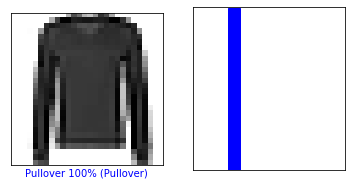

In [31]:
#Checking the 12th image
ith_term = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1) #nrow, ncol, index
plot_image(ith_term, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(ith_term, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

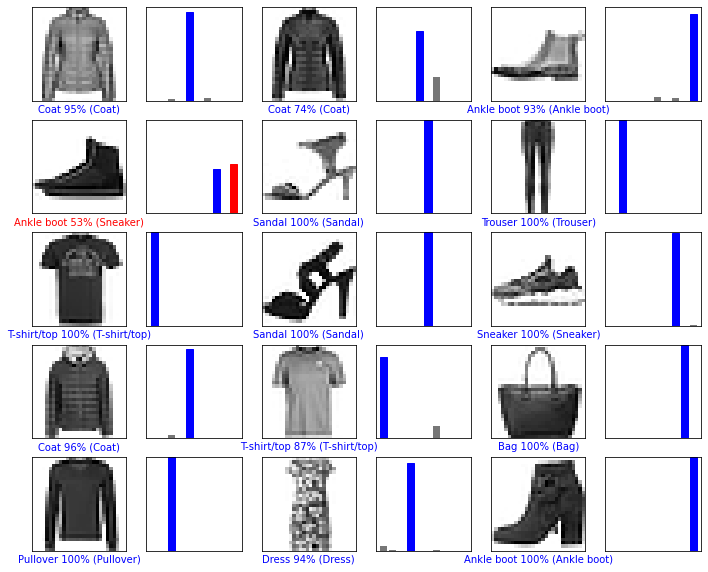

In [38]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
rows = 5
cols = 3
num_images = rows*cols
plt.figure(figsize=(2*2*cols, 2*rows))
for i in range(num_images):
    plt.subplot(rows, 2*cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(rows, 2*cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)

Finally, use the trained model to make a prediction about a single image.



In [39]:
# Grab an image from the test dataset
test_img = test_images[0]
print(test_img.shape)

(28, 28, 1)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [40]:
## Add the image to a batch where it's the only member.
img = np.array([test_img])

print(img.shape)

(1, 28, 28, 1)


In [41]:
predictions_single = model.predict(img)

print(predictions_single)

[[3.7422471e-04 1.1477515e-05 1.6429912e-02 2.0719895e-06 9.5196199e-01
  8.2655838e-09 3.1120559e-02 5.1977999e-08 9.9418554e-05 1.9964121e-07]]


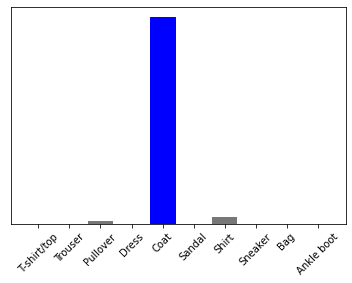

In [43]:
#plot the value in graph
plot_value_array(0, predictions, test_labels)
ticks = plt.xticks(range(10), class_names, rotation=45)

model.predict returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

[31]
0s


In [44]:
print(np.argmax(predictions_single[0]))

4
